# Tarefa 5: Keras Titanic

Neste exercício resolveremos o problema do Kaggle Titanic com a classe MLP criada utilizando o Keras

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
#import umap
from collections import Counter
import re
import datetime
from tqdm import tqdm

from sklearnex import patch_sklearn, unpatch_sklearn
patch_sklearn()
#unpatch_sklearn()

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin


#from sklearn.pipeline import Pipeline
#from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

from tqdm import tqdm



np.__version__, pd.__version__, sklearn.__version__, matplotlib.__version__, sns.__version__#, umap.__version__

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


('1.22.3', '1.4.2', '1.0.2', '3.5.1', '0.11.2')

In [2]:
from numpy import dtype

# Dataset capturado do desafio https://www.kaggle.com/c/titanic/data
df = pd.read_csv('../data/titanic/train.csv')
df_test = pd.read_csv('../data/titanic/test.csv')

y = df.Survived.copy()
X = df.drop('Survived',axis=1).copy()
X_test = df_test.copy()
X.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [3]:
list(Counter(y).values())/y.count(),Counter(y)

(array([0.61616162, 0.38383838]), Counter({0: 549, 1: 342}))

In [4]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from collections import Counter
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


def getInt(x):
    try: t = int(x)
    except: t = np.nan
    return t

class TitanicTransformEngFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, exclude_unused=['PassengerId', 'Ticket', 'Cabin','Name'],
                 ordinal_pclass=True,
                 include_feats=['AgeGroup','NameTitle','SurNameFrequency','CabinsCount',
                                'CabinsDeck','CabinsDeckMaxNumber','CabinsDeckMaxZone',
                                'CabinsDeckMinNumber',
                                'TicketType', 'TicketFrequency',
                                'FamilySize','IsAlone',
                                'NaiveSurviveProba'
                                  ]):
        self.exclude_unused = exclude_unused
        self.ordinal_pclass = ordinal_pclass
        self.include_feats = include_feats 
        

    def fit(self, X, y=None):
        
        # Check that X and y have correct shape
        #X, y = check_X_y(X, y)
        if not isinstance(X, pd.DataFrame): raise Exception('X must be a pandas Dataframe')
        self.features_ = X.columns
        self.X_ = X.copy()
        if not(y is None): self.y_ = y.copy()
        else: self.y_ = None
        
        
        #Begin fitting transformer
        
        self.tobe_removed = self.exclude_unused
        
        return self
    
    def transform(self, X, y=None):

        # Check is fit had been called
        check_is_fitted(self)
        Xs = X.copy()

        if self.ordinal_pclass: Xs['Pclass'] = pd.Categorical(Xs.Pclass,categories=[1,2,3],ordered=True)
        else: Xs['Pclass'] = Xs.Pclass.astype('object')
            
        Xs['Age'] = Xs.Age//1
        Xs['Fare'] = Xs.Fare//1
        
        if 'AgeGroup' in self.include_feats: Xs['AgeGroup'] = self.getAgeGroup(Xs.Age)

        if 'NameTitle' in self.include_feats: Xs['NameTitle'] = Xs.Name.apply(self.getTitle)
        if 'SurNameFrequency' in self.include_feats: Xs['SurNameFrequency'] = Xs.Name.apply(self.getSurNameFrequency,args=(self.X_.Name,self,))
        if 'Family' in self.include_feats: Xs['Family'] = self.getFamilies(Xs,self)    

        if 'CabinsCount' in self.include_feats: Xs['CabinsCount'] = Xs.Cabin.apply(self.getCabinsCount)
        if 'CabinsDeck' in self.include_feats: Xs['CabinsDeck'] = Xs.Cabin.apply(self.getCabinsDeck)
        if 'CabinsDeckMaxNumber' in self.include_feats: Xs['CabinsDeckMaxNumber'] = Xs.Cabin.apply(self.getCabinsDeckMaxNumber)
        if 'CabinsDeckMinNumber' in self.include_feats: Xs['CabinsDeckMinNumber'] = Xs.Cabin.apply(self.getCabinsDeckMinNumber)
        if 'CabinsDeckMaxZone' in self.include_feats: Xs['CabinsDeckMaxZone'] = Xs.Cabin.apply(self.getCabinsDeckMaxZone,args=(self,10,30,))

        if 'TicketType' in self.include_feats: Xs['TicketType'] = Xs.Ticket.apply(self.getTicketType)
        if 'TicketFrequency' in self.include_feats: Xs['TicketFrequency'] = Xs.Ticket.apply(self.getTicketFrequency,args=(self.X_.Ticket,self,))
        
        if 'FamilySize' in self.include_feats: Xs['FamilySize'] = Xs.apply(self.getFamilySize,axis=1)
        if 'IsAlone' in self.include_feats: Xs['IsAlone'] = Xs.apply(self.getIsAlone,axis=1)
        if not (self.y_ is None) and 'NaiveSurviveProba' in self.include_feats: 
            Xs['NaiveSurviveProba'] = Xs.apply(self.getNaiveSurviveProba,args=(self,self.X_,self.y_,),axis=1)    

        Xs = Xs.drop(self.tobe_removed,axis=1)


        return Xs
    
    #FEATURE ENG METHODS
    
    ###########
    # Categorical age by logial fixed split
    #########
    @staticmethod
    def getAgeGroup(x):
        bins = [0, 2, 12, 17, 30, 45, 60, np.inf]
        labels = ['baby', 'child', 'teen', 'young' ,'adult', 'senior' ,'elderly']
        return pd.cut(x, bins = bins, labels = labels)       

    ###########
    # Get surname of a passager
    #########    
    @staticmethod   
    def getSurName(s):
        #return s.split(',')[0].strip()
        r = s.split(',')[0]
        l = re.findall(r'([A-Za-z]+)',r)
        r = ''.join(l).lower()
        return r

    ###########
    # Get number of people with same surname
    #########
    @staticmethod
    def getSurNameFrequency( s, s_col, self):
        l = Counter(s_col.apply(self.getSurName))
        return l.get(self.getSurName(s),1)

    ###########
    # Get title from name
    #########    
    @staticmethod
    def getTitle(s):
        t = s.split(', ')[1].split('.')[0].strip()
        return {
            'Mr': 'Married man',
            'Mrs': 'Married woman',
            'Master': 'Single man',
            'Miss': 'Single woman',
            'Ms': 'Single woman',
            'Lady': 'Single woman',
            'Jonkheer': 'Married man',
            'Major': 'Oficial',
            'Dr': 'Oficial',
            'Col': 'Oficial',
            'Capt': 'Oficial',
            'Cap': 'Oficial',
            'Oficial': 'Oficial',
        }.get(t,'NA')

    ###########
    # Get cabin count per ticket
    #########    
    @staticmethod
    def getCabinsCount(s):
        if isinstance(s, str): t = len(s.split(' '))#.notnull().sum(axis=1)
        else: t = 0
        return int(t)



    ###########
    # Get cabin deck (see exploratory analysis at end of this exercise)
    #########    
    @staticmethod
    def getCabinsDeck(s):
        if isinstance(s, str): 
            l = s.split(' ')
            x = np.array([(x[0],x[1:]) for x in l])
            t = sorted(x[:,0])[-1]

        else: t = 'NA'

        return t

    ###########
    # Get Cabin deck number, to inference the location of deck inside the ship
    #########    
    @staticmethod
    def getCabinsDeckMaxNumber(s):
        if isinstance(s, str): 
            l = s.split(' ')
            l = np.array([(x[0],x[1:]) for x in l])
            l = l[:,1]
            l = np.array([getInt(x) for x in l])
            l = np.nan_to_num(l,nan=-np.inf)
            t = l[l.argmax()]
            try: t = int(t)
            except: t= -1

        else: t = -1

        return int(t)

    ###########
    # Get fixed category of cabin number at deck
    #########    
    @staticmethod
    def getCabinsDeckMaxZone(s,self,lowcut=10,midcut=40):
        n = self.getCabinsDeckMaxNumber(s)
        if n <= 0 : return('NA')
        if n <= lowcut: return('low')
        if n <= midcut: return('mid')
        else: return('high')

    ###########
    # Get Minimum number of deck for tickets with more than one cabin
    #########    
    @staticmethod
    def getCabinsDeckMinNumber(s):
        if isinstance(s, str): 
            l = s.split(' ')
            l = np.array([(x[0],x[1:]) for x in l])
            l = l[:,1]
            l = np.array([getInt(x) for x in l])
            l = np.nan_to_num(l,nan=np.inf)
            t = l[l.argmin()]
            try: t = int(t)
            except: t= -1

        else: t = -1

        return int(t) 

    ###########
    # Get Cabin deck number, to inference the location of deck inside the ship
    #########    
    @staticmethod
    def getTicketType(s):
        l = re.findall('([a-zA-Z]+)',s)
        r = ''.join(l).upper()
        return r

    ###########
    # Extract just the numbers of the ticket
    #########    
    @staticmethod
    def getTicketNumber(s):
        l = re.findall(r'\b\d+\b',s)
        r = ''.join(l).upper()
        return r

    ###########
    # Get the number of people with the same ticket number
    #########
    @staticmethod
    def getTicketFrequency( s, s_col, self):
        l = Counter(s_col.apply(self.getTicketNumber))
        return l.get(self.getTicketNumber(s),1)

    ###########
    # Get family size onboard
    #########
    @staticmethod
    def getFamilySize(x):
        return x.SibSp + x.Parch

    ###########
    # Binary feature if passager is alone
    #########
    @staticmethod
    def getIsAlone(x):
        return ((x.SibSp + x.Parch)<1)//1    

    ###########
    # Get inference of families onboad
    #########    
    @staticmethod
    def getFamilies(X,self):
        x = X.Name.apply(self.getSurName)+ X.Ticket.apply(self.getTicketNumber)
        return x

    ###########
    # Calculate a naive probability of survival. This feature alone scored 0.79 on kaggle (not posted on first
    # exercise, because its a sort of "cheating" or "manual learning", and not machine learning)
    #########  
    @staticmethod
    def getNaiveSurviveProba(x,self,X_train,y_train,min_group=3,div_fare=10,div_age=2):
        Xs = X_train.join(y_train).copy()
        xt = x.copy()

        if not isinstance(x, pd.Series): raise Exception('x must be a pandas Series of Titanic dataset')

        Xs['Fare'] = Xs['Fare']//div_fare
        Xs['Age'] = Xs['Age']//div_age
        Xs['FamilySize'] = Xs.SibSp + Xs.Parch
        Xs['Alone'] = (Xs['FamilySize']<1)//1

        if xt.notnull().Fare: xt['Fare'] = xt['Fare']//div_fare
        if xt.notnull().Age:  xt['Age'] = xt['Age']//div_age
        xt['FamilySize'] = xt.SibSp + xt.Parch
        xt['Alone'] = (xt['FamilySize']<1)//1

        row = xt

        p=0
        p1 = Xs['Survived'][Xs['Sex'] == row['Sex']][Xs['Pclass'] == row['Pclass']]
        p2 = Xs['Survived'][Xs['Sex'] == row['Sex']][Xs['Fare'] == row['Fare']]
        p3 = Xs['Survived'][Xs['Sex'] == row['Sex']][Xs['Age'] == row['Age']]
        p4 = Xs['Survived'][Xs['Sex'] == row['Sex']][Xs['FamilySize'] == row['FamilySize']]
        p5 = Xs['Survived'][Xs['Sex'] == row['Sex']][Xs['Alone'] == row['Alone']]
        p6 = Xs['Survived'][Xs['Sex'] == row['Sex']][Xs['Ticket'] == row['Ticket']]
        p7 = Xs['Survived'][Xs['Sex'] == row['Sex']][Xs['Embarked'] == row['Embarked']]

        if len(p1) and len(p1)>min_group : p = max(p,sum(p1)/len(p1)) #; print('p1 :', sum(p1)/len(p1))
        if len(p2) and len(p2)>min_group : p = max(p,sum(p2)/len(p2)) #; print('p2 :', sum(p2)/len(p2))
        if len(p3) and len(p3)>min_group : p = max(p,sum(p3)/len(p3)) #; print('p3 :', sum(p3)/len(p3))
        if len(p4) and len(p4)>min_group : p = max(p,sum(p4)/len(p4)) #; print('p3 :', sum(p3)/len(p3))
        if len(p5) and len(p5)>min_group : p = max(p,sum(p5)/len(p5)) #; print('p3 :', sum(p3)/len(p3))
        if len(p6) and len(p6)>min_group : p = max(p,sum(p6)/len(p6)) #; print('p3 :', sum(p3)/len(p3))
        if len(p7) and len(p7)>min_group : p = max(p,sum(p7)/len(p7)) #; print('p3 :', sum(p3)/len(p3))

        return 100*p//1


## Teste de transformação dos dados e visualização das features criadas vs Survived

In [5]:
aux = TitanicTransformEngFeatures().fit_transform(X,y)
display(aux.describe(include='all').T)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Pclass,891.0,3.0,3.0,491.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,714.0,NaN,NaN,NaN,29.679272,14.536483,0.0,20.0,28.0,38.0,80.0
SibSp,891.0,NaN,NaN,NaN,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
Parch,891.0,NaN,NaN,NaN,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
Fare,891.0,NaN,NaN,NaN,31.785634,49.70373,0.0,7.0,14.0,31.0,512.0
Embarked,889,3,S,644,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AgeGroup,707,7,young,298,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NameTitle,891,6,Married man,518,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SurNameFrequency,891.0,NaN,NaN,NaN,1.882155,1.488014,1.0,1.0,1.0,2.0,9.0


<AxesSubplot:xlabel='NaiveSurviveProba', ylabel='Survived'>

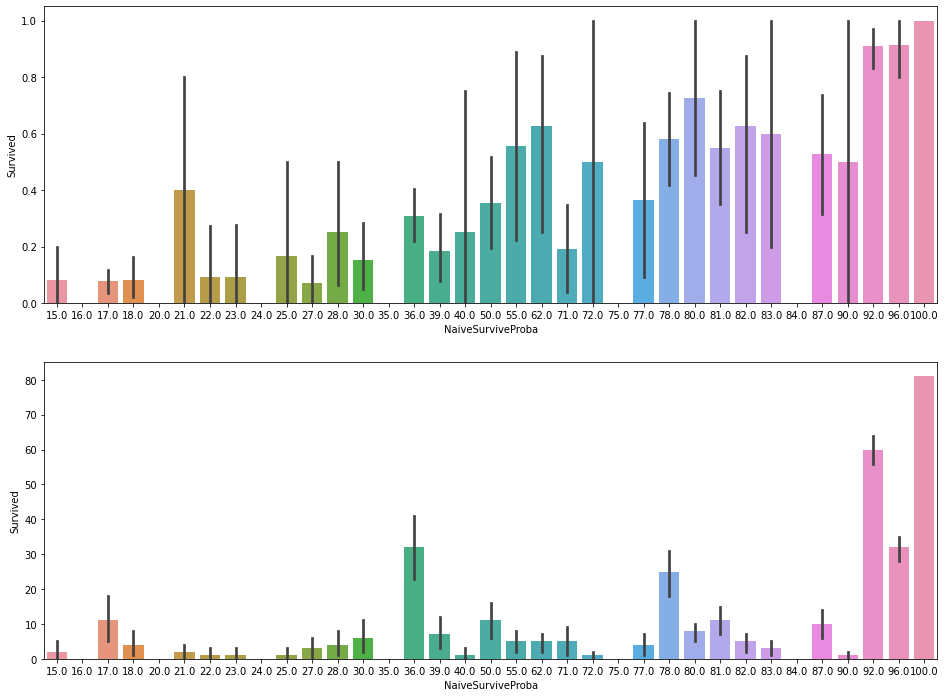

In [6]:
fig, ax = plt.subplots(figsize=(16,12),nrows=2)
sns.barplot(x="NaiveSurviveProba", y="Survived",data=aux.join(y),ax=ax[0])
sns.barplot(x="NaiveSurviveProba", y="Survived",estimator=sum,data=aux.join(y),ax=ax[1])

<AxesSubplot:xlabel='FamilySize', ylabel='Survived'>

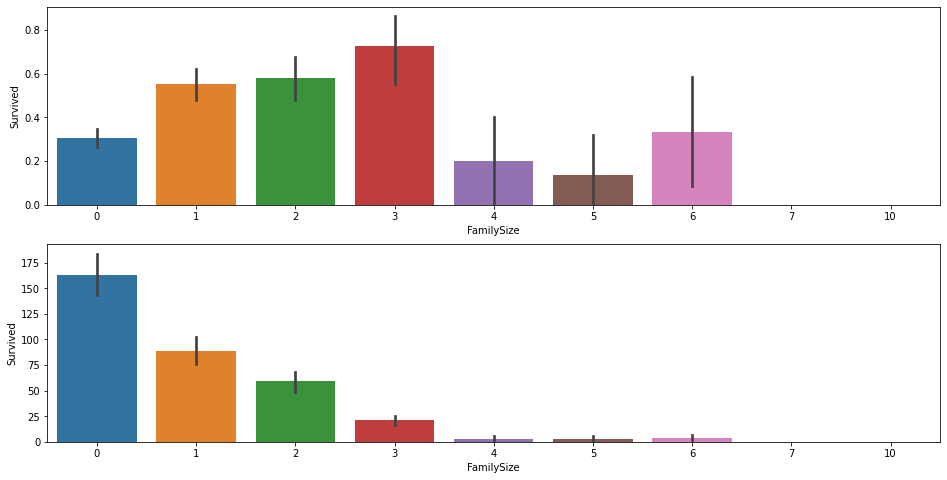

In [7]:
fig, ax = plt.subplots(figsize=(16,8),nrows=2)
sns.barplot(x="FamilySize", y="Survived",data=aux.join(y),ax=ax[0])
sns.barplot(x="FamilySize", y="Survived",estimator=sum,data=aux.join(y),ax=ax[1])

<AxesSubplot:xlabel='IsAlone', ylabel='Survived'>

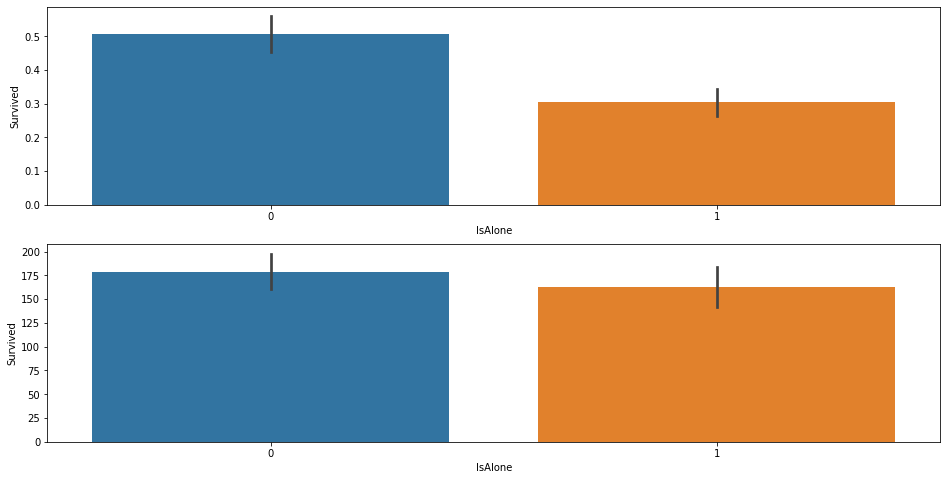

In [8]:
fig, ax = plt.subplots(figsize=(16,8),nrows=2)
sns.barplot(x="IsAlone", y="Survived",data=aux.join(y),ax=ax[0])
sns.barplot(x="IsAlone", y="Survived",estimator=sum,data=aux.join(y),ax=ax[1])

<AxesSubplot:xlabel='SurNameFrequency', ylabel='Survived'>

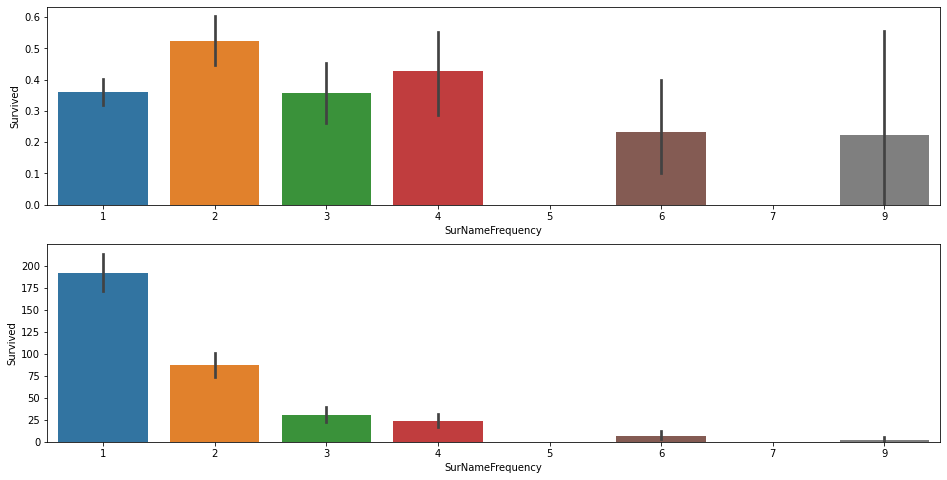

In [9]:
fig, ax = plt.subplots(figsize=(16,8),nrows=2)
sns.barplot(x="SurNameFrequency", y="Survived",data=aux.join(y),ax=ax[0])
sns.barplot(x="SurNameFrequency", y="Survived",estimator=sum,data=aux.join(y),ax=ax[1])

<AxesSubplot:xlabel='TicketFrequency', ylabel='Survived'>

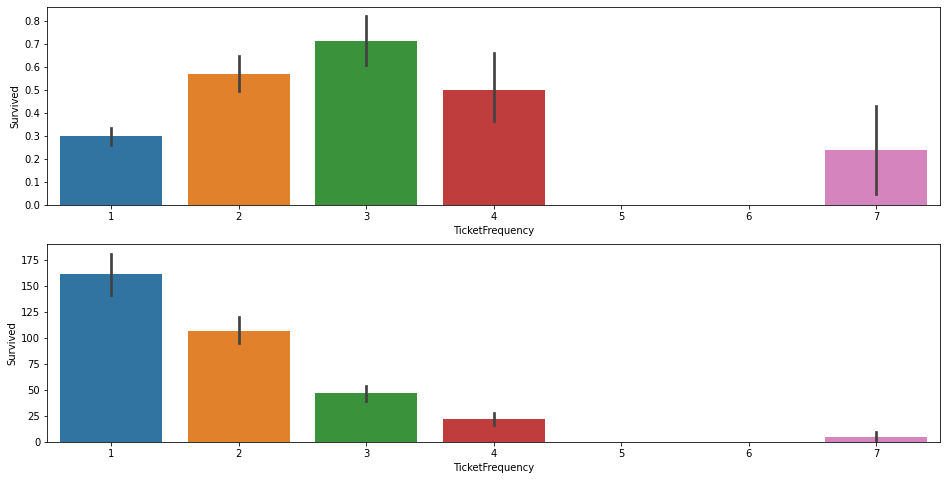

In [10]:
fig, ax = plt.subplots(figsize=(16,8),nrows=2)
sns.barplot(x="TicketFrequency", y="Survived",data=aux.join(y),ax=ax[0])
sns.barplot(x="TicketFrequency", y="Survived",estimator=sum,data=aux.join(y),ax=ax[1])

<AxesSubplot:xlabel='CabinsDeck', ylabel='Survived'>

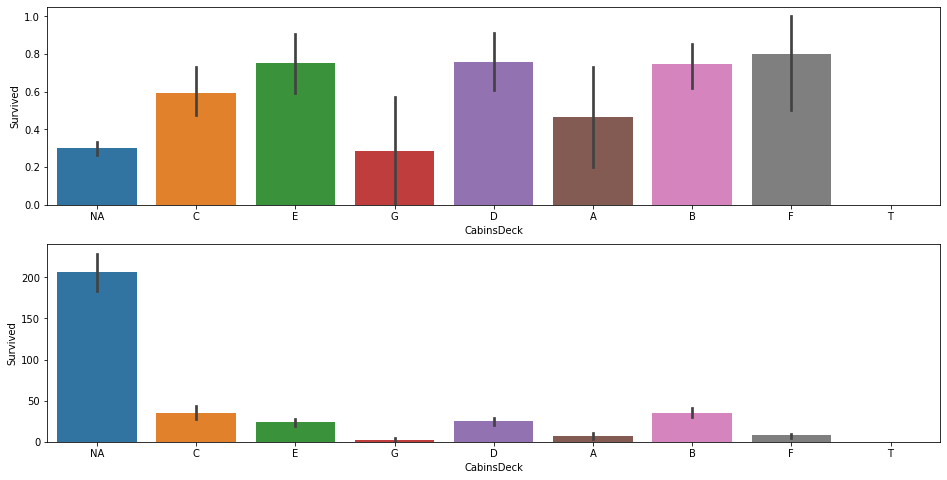

In [11]:
fig, ax = plt.subplots(figsize=(16,8),nrows=2)
sns.barplot(x="CabinsDeck", y="Survived",data=aux.join(y),ax=ax[0])
sns.barplot(x="CabinsDeck", y="Survived",estimator=sum,data=aux.join(y),ax=ax[1])

<AxesSubplot:xlabel='CabinsCount', ylabel='Survived'>

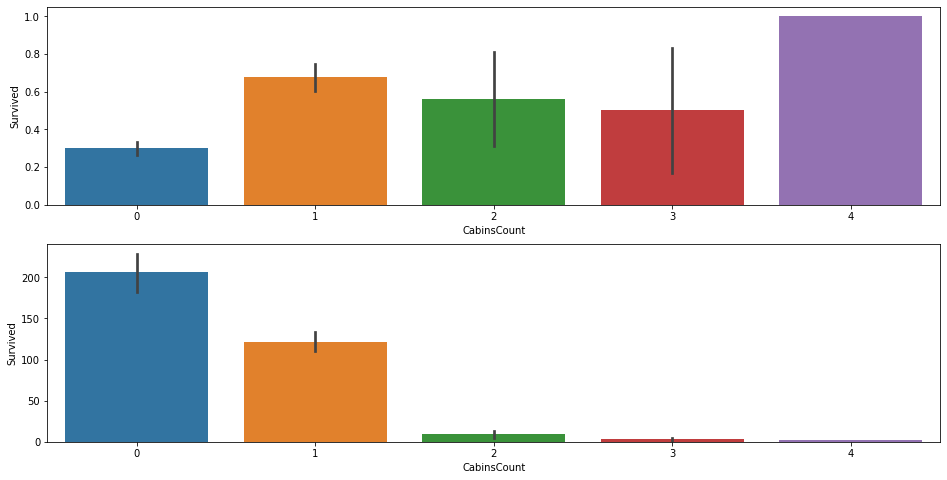

In [12]:
fig, ax = plt.subplots(figsize=(16,8),nrows=2)
sns.barplot(x="CabinsCount", y="Survived",data=aux.join(y),ax=ax[0])
sns.barplot(x="CabinsCount", y="Survived",estimator=sum,data=aux.join(y),ax=ax[1])

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

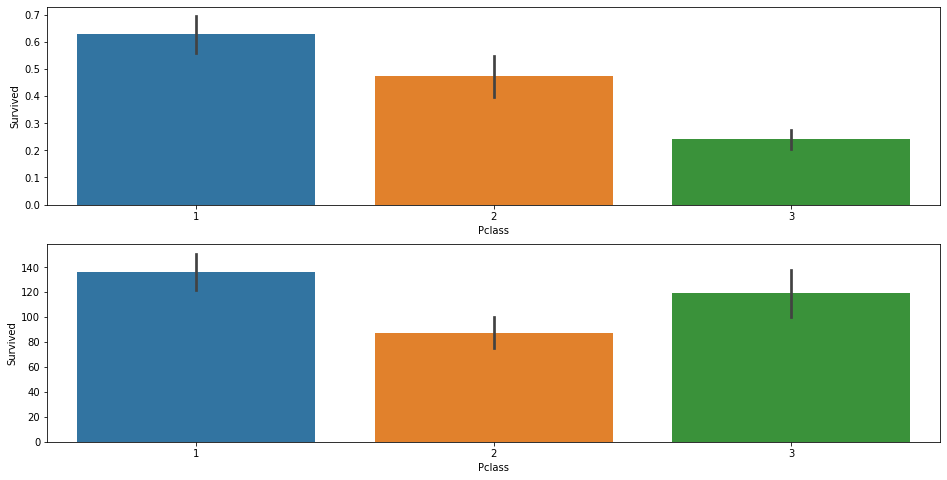

In [13]:
fig, ax = plt.subplots(figsize=(16,8),nrows=2)
sns.barplot(x="Pclass", y="Survived",data=aux.join(y),ax=ax[0])
sns.barplot(x="Pclass", y="Survived",estimator=sum,data=aux.join(y),ax=ax[1])

<AxesSubplot:xlabel='AgeGroup', ylabel='Survived'>

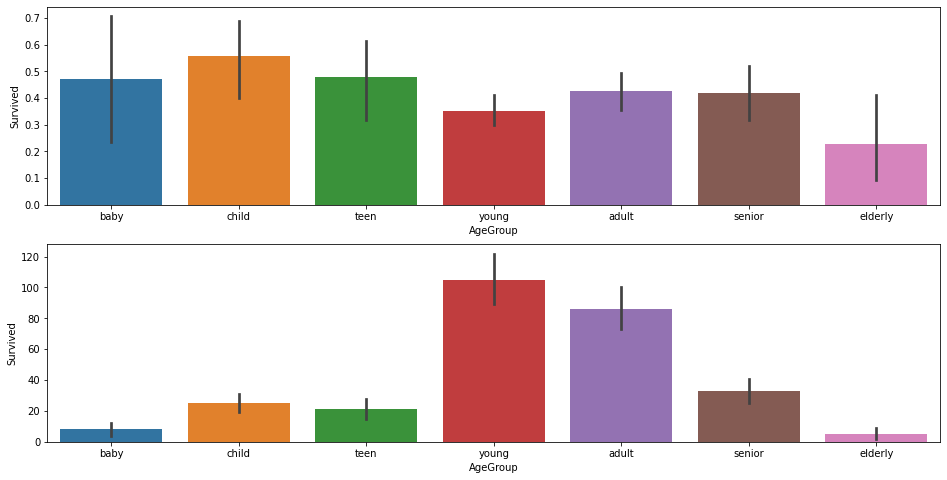

In [14]:
fig, ax = plt.subplots(figsize=(16,8),nrows=2)
sns.barplot(x="AgeGroup", y="Survived",data=aux.join(y),ax=ax[0])
sns.barplot(x="AgeGroup", y="Survived",estimator=sum,data=aux.join(y),ax=ax[1])

<AxesSubplot:xlabel='Embarked', ylabel='Survived'>

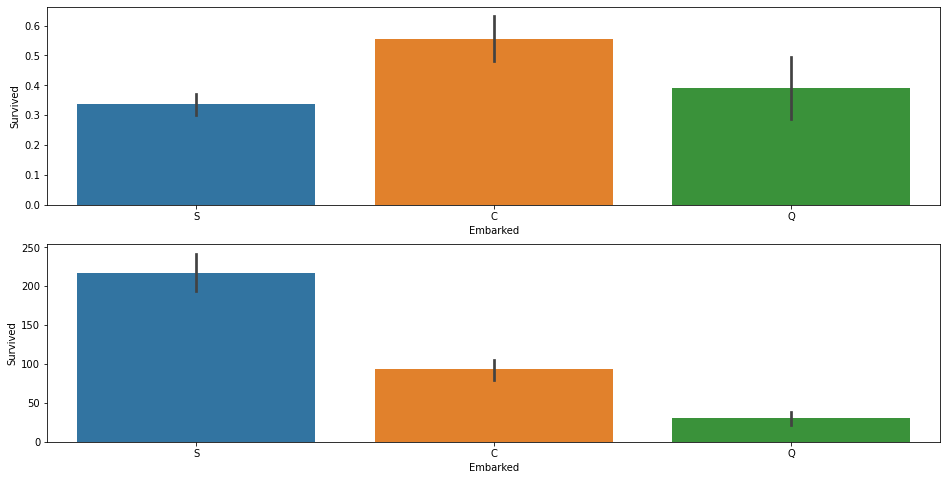

In [15]:
fig, ax = plt.subplots(figsize=(16,8),nrows=2)
sns.barplot(x="Embarked", y="Survived",data=aux.join(y),ax=ax[0])
sns.barplot(x="Embarked", y="Survived",estimator=sum,data=aux.join(y),ax=ax[1])

<AxesSubplot:xlabel='NameTitle', ylabel='Survived'>

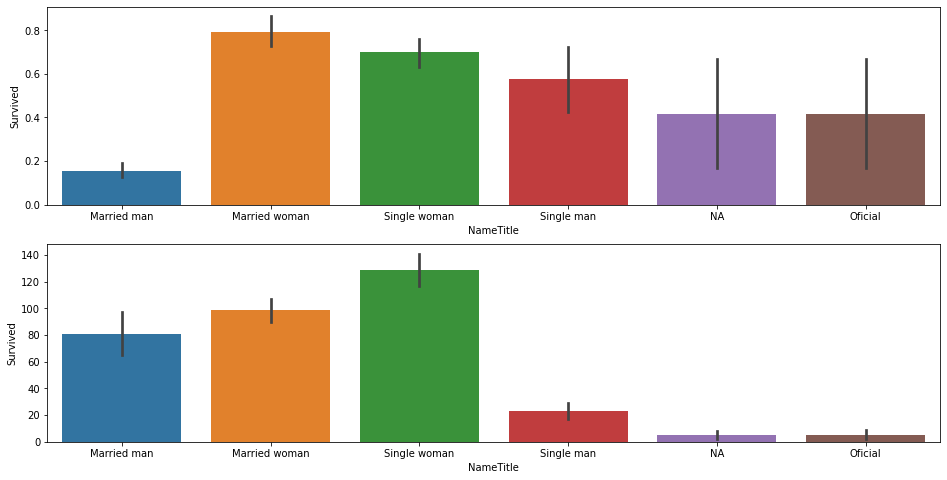

In [16]:
fig, ax = plt.subplots(figsize=(16,8),nrows=2)
sns.barplot(x="NameTitle", y="Survived",data=aux.join(y),ax=ax[0])
sns.barplot(x="NameTitle", y="Survived",estimator=sum,data=aux.join(y),ax=ax[1])

# Criação do Pipeline para limpeza dos dados e preparação para execução do modelo

In [17]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer,IterativeImputer,KNNImputer

# NAO USADO AINDA
class GenericImputer(BaseEstimator, TransformerMixin):
    def __init__(self, cat_imputer = SimpleImputer(strategy='most_frequent')):
        self.feature_names_in_ = None
        self.colunasNumericas = None

    
    def fit(self, X, y=None):
        # Check that X and y have correct shape
        if not isinstance(X, pd.DataFrame): raise Exception('X must be a pandas Dataframe')
        
        self.n_features_in_ = len(X.columns)
        self.feature_names_in_ = X.columns
        
        self.colunasNumericas = X.select_dtypes(include='number').columns
        self.colunasCategoricas = X.select_dtypes(exclude='number').columns
               
        return self
    
    def transform(self, X, y=None):
        # Check is fit had been called
        #check_is_fitted(self)
        if not isinstance(X, pd.DataFrame): raise Exception('X must be a pandas Dataframe')
               
        return X[self.colunasNumericas].to_numpy()

In [18]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer,IterativeImputer,KNNImputer

class AtributosNumericos(BaseEstimator, TransformerMixin):
    def __init__(self ):
        self.feature_names_in_ = None
        self.colunasNumericas = None

    
    def fit(self, X, y=None):
        # Check that X and y have correct shape
        if not isinstance(X, pd.DataFrame): raise Exception('X must be a pandas Dataframe')
        
        self.n_features_in_ = len(X.columns)
        self.feature_names_in_ = X.columns
        
        self.colunasNumericas = X.select_dtypes(include='number').columns
        self.colunasCategoricas = X.select_dtypes(exclude='number').columns
               
        return self
    
    def transform(self, X, y=None):
        # Check is fit had been called
        #check_is_fitted(self)
        if not isinstance(X, pd.DataFrame): raise Exception('X must be a pandas Dataframe')
               
        return X[self.colunasNumericas]#.to_numpy()

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin

class AtributosCategoricos(BaseEstimator, TransformerMixin):
    def __init__(self ):
        self.feature_names_in_ = None
        self.colunasCategoricas = None

    def fit(self, X, y=None):
        # Check that X and y have correct shape
        if not isinstance(X, pd.DataFrame): raise Exception('X must be a pandas Dataframe')
        
        self.n_features_in_ = len(X.columns)
        self.feature_names_in_ = X.columns
    
        self.colunasNumericas = X.select_dtypes(include='number').columns        
        self.colunasCategoricas = X.select_dtypes(exclude='number').columns
        
        return self
    
    def transform(self, X, y=None):
        # Check is fit had been called
        #check_is_fitted(self)
        if not isinstance(X, pd.DataFrame): raise Exception('X must be a pandas Dataframe')
        
        return X[self.colunasCategoricas]#.to_numpy()

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin


class CorrelationThreshold(BaseEstimator, TransformerMixin):
    def __init__(self ,corr_tresh = 0.99, method='pearson'):
        self.corr_tresh = corr_tresh
        self.method = method
        self.high_corr_ = []
        self.fitted_numpy_ = False

    def fit(self, X, y=None):
        # Check that X and y have correct shape
        if not isinstance(X, pd.DataFrame): 
            Xs = pd.DataFrame(X)
            self.fitted_numpy_ = True
        else: 
            Xs = X
            
        
        self.high_corr_ = self.correlated_features(Xs,self.corr_tresh,self.method)
        return self
    
    def transform(self, X, y=None):
        # Check is fit had been called
        #check_is_fitted(self)
        if not isinstance(X, pd.DataFrame): 
            if self.fitted_numpy_ :
                Xs = pd.DataFrame(X)
            else:
                raise Exception('Fit() wasnt a numpy array')
        else: 
            if self.fitted_numpy_: 
                Xs=pd.DataFrame(X.to_numpy())
            else:
                Xs=X
            
        Xs = Xs.drop(self.high_corr_,axis=1)
        
        return Xs.to_numpy()
    
    @staticmethod
    def correlated_features(X, corr_tresh = 0.99,method='pearson'):
        """
        Identifies features that are highly correlated. Let's assume that if
        two features or more are highly correlated, we can randomly select
        one of them and discard the rest without losing much information.


        Parameters
        ----------
        X : pandas dataframe
            A data set where each row is an observation and each column a feature.

        correlation_threshold: float, optional (default = 0.99)
            The threshold used to identify highly correlated features.

        Returns
        -------
        labels: list
            A list with the labels identifying the features that contain a 
            large fraction of constant values.
        """

        # Make correlation matrix
        corr_matrix = X.corr(method = method).abs()


        # Select upper triangle of matrix
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(bool))

        # Find index of feature columns with correlation greater than correlation_threshold
        labels = [column for column in upper.columns if any(upper[column] >  corr_tresh)]

        return labels

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin

#UNUSED FOR NOW
class FeatureSelector( BaseEstimator, TransformerMixin ):

    #Class Constructor 
    def __init__( self, rfecv_support,sfscv_support ):
        self.rfecv_support = rfecv_support
        self.sfscv_support = sfscv_support

    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 

    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return X[:,self.rfecv_support][:,np.r_[self.sfscv_support]]

In [22]:
from sklearn.experimental import enable_iterative_imputer

from sklearn.impute import SimpleImputer,IterativeImputer,KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.feature_selection import RFECV,SequentialFeatureSelector,VarianceThreshold
#from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.pipeline import Pipeline
import lightgbm as lgb
#from xgboost  import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.ensemble import RandomForestClassifier

#from tpot import TPOTClassifier

SplitUnionPipeline = Pipeline([
    ('unecaracteristicas', FeatureUnion([
        ('pipenum', Pipeline([
            ('atributos_numericos', AtributosNumericos()),
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])),
        ('pipecat', Pipeline([
            ('atributos_categoricos', AtributosCategoricos()),
            ('imputer',SimpleImputer(strategy='constant', fill_value='NA')),
            ('encoder', OneHotEncoder(handle_unknown='ignore',sparse=False))
            
        ]))
    ])),
])

FeaturePipe = Pipeline([
    ('atributosDesejados', TitanicTransformEngFeatures()),
    ('trataAtributos', SplitUnionPipeline),
    ('varselec', VarianceThreshold(0.1)),
    ('corrtresh', CorrelationThreshold(0.98))
])






In [23]:
%%time
FeaturePipe.fit_transform(X).shape


CPU times: total: 2.69 s
Wall time: 3.05 s


(891, 25)

In [24]:
import tensorflow as tf
from tensorflow import keras
import gc

from tensorflow.keras import Sequential, layers, losses
from tensorflow.keras.models import Model
#from tensorflow.keras.datasets import fashion_mnist
from tqdm.keras import TqdmCallback

DEBUG = 'DEBUG: '

tf.keras.backend.clear_session()
gc.collect()

def disable_gpu_tf():
  try:
      # Disable all GPUS
      tf.config.set_visible_devices([], 'GPU')
      visible_devices = tf.config.get_visible_devices()
      for device in visible_devices:
        print(DEBUG,visible_devices)
        assert device.device_type != 'GPU'
  except:
      # Invalid device or cannot modify virtual devices once initialized.
      pass

print(DEBUG,tf.__version__)
print(DEBUG,tf.config.get_visible_devices())
disable_gpu_tf()

d:\ProgramData\Miniconda3\envs\ppcompts\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DEBUG:  2.6.0
DEBUG:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
DEBUG:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [25]:
tf.keras.backend.clear_session()
gc.collect()

class MLPKerasClassifier(BaseEstimator,ClassifierMixin):
  def __init__(self,max_iter=1000,n_hidden=[5,4],hidden_activation='relu',batch_size=None
              ,optimizer=tf.keras.optimizers.Adam,learning_rate=0.001,dropout=0.2
              ,es_patience=20,es_monitor='val_loss',validation_split=0.2
              ,use_multiprocessing =True
              ):
    self.max_iter = max_iter
    self.n_hidden = n_hidden
    self.batch_size = batch_size 
    self.hidden_activation = hidden_activation
    self.dropout = dropout
    self.learning_rate = learning_rate
    self.optimizer = optimizer
    self.opt = optimizer(learning_rate=learning_rate)
    self.validation_split = validation_split
    self.es_patience = es_patience
    self.es_monitor = es_monitor
    self.use_multiprocessing = use_multiprocessing
    self.history_ = {}
    self.es = tf.keras.callbacks.EarlyStopping(
                              monitor=es_monitor,
                              min_delta=0,
                              patience=es_patience,
                              verbose=0,
                              mode='auto',
                              restore_best_weights=True
                          )

  def fit(self,X,y):
    self.labels,ids = np.unique(y,return_inverse=True)
    yhot = tf.keras.utils.to_categorical(ids)
    self.model = tf.keras.models.Sequential()
    self.model.add(tf.keras.layers.InputLayer(input_shape=(X.shape[1],)))
    
    if self.n_hidden:
      for i,h in enumerate(self.n_hidden):
        #print(DEBUG,i,h)
        self.model.add(tf.keras.layers.Dense(h))
        self.model.add(tf.keras.layers.Dropout(self.dropout))
        if i<len(self.n_hidden)-1:
          self.model.add(tf.keras.layers.Activation(self.hidden_activation))

      self.model.add(tf.keras.layers.Activation(self.hidden_activation))
    self.model.add(tf.keras.layers.Dense(yhot.shape[1],name='last_layer'))
    self.model.add(tf.keras.layers.Activation('softmax',name='softmax'))    
    self.model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=self.opt)
    new_history = self.model.fit(X,yhot,batch_size=self.batch_size,epochs=self.max_iter,verbose=0
                      ,validation_split=self.validation_split,callbacks=[self.es,TqdmCallback()]
                      ,use_multiprocessing = self.use_multiprocessing)
    self.history_ = self.appendHist(self.history_,new_history.history)
    self.coef_ = self.model.get_weights()
  
  def predict(self,X):
    predictions = self.model.predict(X)
    return self.labels[np.argmax(predictions,axis=1)]
  
  def summary(self):
    self.model.summary()
    print(self.model.get_weights()[0])
    print(self.model.get_weights()[1])
    self.plotHistory()
  
  def plotHistory(self,yscale='linear',bfilter=2):
      plt.plot(self.history_["loss"][bfilter:], label="Training Loss")
      plt.yscale(yscale)
      try: 
        plt.plot(self.history_["val_loss"][bfilter:], label="Validation Loss")
        plt.yscale(yscale)
      except: pass
      plt.legend()
      plt.show()

  def appendHist(self, h1, h2):
    if h1 == {}:
        return h2
    else:
        dest = {}
        for key, value in h1.items():
            dest[key] = value + h2[key]
        return dest

In [26]:
clf = MLPKerasClassifier(n_hidden=[12,6],hidden_activation='tanh',learning_rate=0.001,max_iter=1000)

pipe = Pipeline([
    ('features_pipe',FeaturePipe),
    ('cf',clf)
])

#pipe.fit(X,y)
#pipe.predict(X_test)

In [27]:
%%time
cv = 5#RepeatedStratifiedKFold()
scores = cross_validate(pipe, X, y, return_estimator=True, cv=cv,verbose=2,n_jobs=1)
print(scores['test_score'], np.mean(scores['test_score']), np.std(scores['test_score']))
display(pd.DataFrame(scores).describe().T)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
  6%|▌         | 62/1000 [00:02<00:43, 21.62epoch/s, loss=0.392, accuracy=0.84, val_loss=0.323, val_accuracy=0.874] 


[CV] END .................................................... total time=  10.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.6s remaining:    0.0s
  4%|▍         | 39/1000 [00:01<00:45, 21.22epoch/s, loss=0.411, accuracy=0.828, val_loss=0.371, val_accuracy=0.839]


[CV] END .................................................... total time=   9.3s


  4%|▍         | 42/1000 [00:01<00:44, 21.73epoch/s, loss=0.429, accuracy=0.839, val_loss=0.355, val_accuracy=0.853]


[CV] END .................................................... total time=   9.4s


  7%|▋         | 69/1000 [00:03<00:42, 22.14epoch/s, loss=0.387, accuracy=0.837, val_loss=0.319, val_accuracy=0.86] 


[CV] END .................................................... total time=  11.0s


  0%|          | 0/1000 [00:00<?, ?epoch/s]

  4%|▎         | 36/1000 [00:01<00:47, 20.22epoch/s, loss=0.431, accuracy=0.816, val_loss=0.408, val_accuracy=0.804]


[CV] END .................................................... total time=   9.7s
[0.81005587 0.79213483 0.78651685 0.81460674 0.84269663] 0.8092021844203126 0.019787544559707593


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   50.5s finished


,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,8.504525,0.731967,7.887295,7.936737,8.124150,9.100363,9.474082
score_time,5.0,1.611394,0.047158,1.557977,1.568996,1.616999,1.647998,1.664998
test_score,5.0,0.809202,0.022123,0.786517,0.792135,0.810056,0.814607,0.842697


CPU times: total: 54.6 s
Wall time: 50.6 s


In [28]:
from sklearn.ensemble import BaggingClassifier

final_pipe = Pipeline([
    ('features_pipe',FeaturePipe),
    ('cf',BaggingClassifier(base_estimator=clf,max_samples=0.8, max_features=0.6,
                        n_estimators=5, bootstrap=False,bootstrap_features=True,random_state=42))
])

In [29]:
%%time
cv = 5 #RepeatedStratifiedKFold()
scores = cross_validate(final_pipe, X, y, return_estimator=True, cv=cv,verbose=2,n_jobs=1)
print(scores['test_score'], np.mean(scores['test_score']), np.std(scores['test_score']))
display(pd.DataFrame(scores).describe().T)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 10%|█         | 104/1000 [00:03<00:32, 27.67epoch/s, loss=0.509, accuracy=0.769, val_loss=0.526, val_accuracy=0.711]


[CV] END .................................................... total time=  24.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.3s remaining:    0.0s
  7%|▋         | 66/1000 [00:02<00:38, 24.17epoch/s, loss=0.497, accuracy=0.774, val_loss=0.608, val_accuracy=0.702]


[CV] END .................................................... total time=  23.5s


  7%|▋         | 74/1000 [00:02<00:35, 25.99epoch/s, loss=0.506, accuracy=0.761, val_loss=0.566, val_accuracy=0.737]


[CV] END .................................................... total time=  20.0s


  9%|▊         | 87/1000 [00:03<00:34, 26.69epoch/s, loss=0.52, accuracy=0.743, val_loss=0.586, val_accuracy=0.711] 


[CV] END .................................................... total time=  21.8s


 12%|█▏        | 118/1000 [00:04<00:32, 27.38epoch/s, loss=0.508, accuracy=0.768, val_loss=0.532, val_accuracy=0.746]


[CV] END .................................................... total time=  20.8s
[0.77653631 0.80337079 0.7752809  0.80898876 0.84269663] 0.8013746783001695 0.02476809278050166


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.8min finished


,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,20.279383,1.796978,18.261374,18.946337,19.984843,21.692784,22.511578
score_time,5.0,1.906607,0.034142,1.869994,1.878000,1.912000,1.918011,1.955029
test_score,5.0,0.801375,0.027692,0.775281,0.776536,0.803371,0.808989,0.842697


CPU times: total: 2min 13s
Wall time: 1min 50s


In [30]:
#final_pipe=pipe
final_pipe.fit(X,y)
y_pred = final_pipe.predict(X_test)
result = X_test[['PassengerId']].copy()
result['Survived'] = y_pred
result.to_csv('submission_final_titanic_v3.csv',index=False)



  9%|▉         | 90/1000 [00:03<00:34, 26.24epoch/s, loss=0.493, accuracy=0.757, val_loss=0.56, val_accuracy=0.72]  


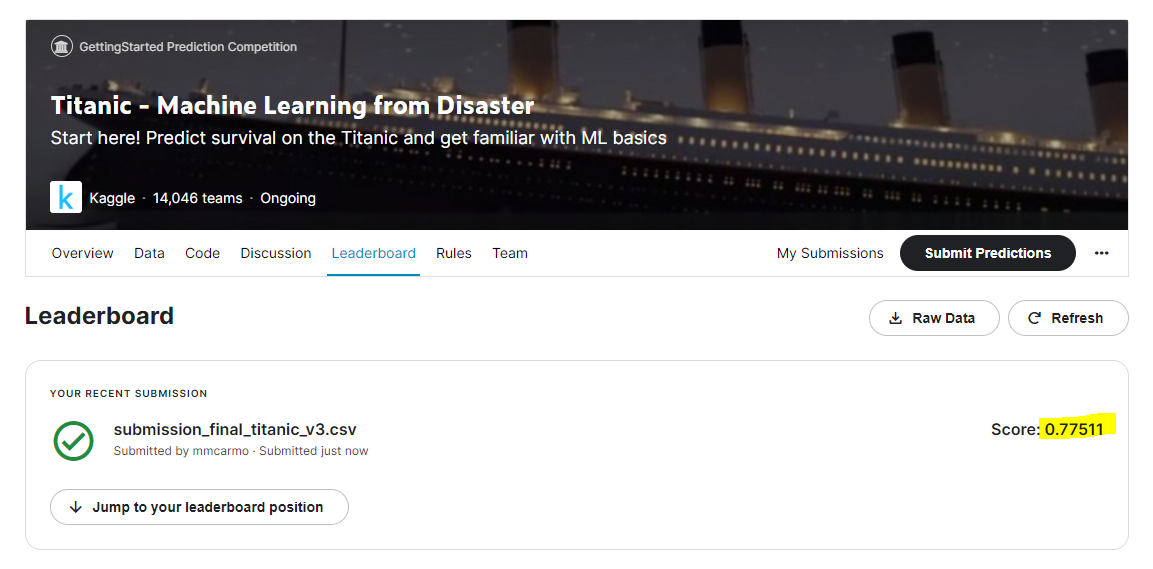

In [65]:
%matplotlib inline
from IPython.display import Image
Image('./Kaggle Score.PNG')

# CONCLUSÃO FINAL: 

### É muito difícil para um dataset tão pequeno conseguimos ao mesmo tempo melhores resultados na validação e nos testes, pois ao tentar estimar melhores resultados para validação acabaremos gerando overfiting, e tendo um desempenho pior nos testes.

In [66]:
import platform
import multiprocessing
    
print(platform.machine())
print(platform.platform())
print('Processor: '+platform.processor())
print('Cores available: '+str(multiprocessing.cpu_count()))

AMD64
Windows-10-10.0.19041-SP0
Processor: Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
Cores available: 12
